In [274]:

import matplotlib
matplotlib.use('GtkAgg')
% matplotlib inline
import matplotlib.pyplot as plt

import rosbag, sys, os, cv2, IPython, math
os.environ['CARLA_VERSION']='0.9.X'
sys.path.append("../../CIL_modular/drive_interfaces/carla/")
sys.path.append('../../CIL_modular/drive_interfaces/carla/carla_client')
from carla_recorder import Recorder
import numpy as np
from operator import itemgetter
from collections import namedtuple

def read_topic(bag, topic, item_transformer=lambda x: x):
    output = []
    for item in bag.read_messages(topics=topic):
        time = item.timestamp.to_nsec()
        content = item_transformer(item.message)
        output.append((time, content))
    return output


-c:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://IPython.kernel.zmq.pylab.backend_inline' by the following code:
  File "<string>", line 1, in <module>
  File "/usr/lib/python2.7/dist-packages/IPython/kernel/zmq/kernelapp.py", line 469, in main
    app.start()
  File "/usr/lib/python2.7/dist-packages/IPython/kernel/zmq/kernelapp.py", line 459, in start
    ioloop.IOLoop.instance().start()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/lib/python2.7/dist-packages/tornado/ioloop.py", line 866, in start
    handler_func(fd_obj, events)
  File "/usr/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/pyt

In [290]:
bag_path = "/scratch/yang/aws_data/human_driving/2018-11-15_09-56-34/bag_1.bag"

In [291]:
bag = rosbag.Bag(bag_path, 'r')


def quaternion_to_yaw(msg):
    q = msg.orientation
    #yaw = math.atan2(2 * (q.x * q.w + q.y * q.z), 1 - 2 * (q.z ** 2 + q.w ** 2))
    pitch = math.atan2(2*(q.x*q.y + q.z*q.w), 1-2*(q.y**2 + q.z**2))
    #roll = math.asin(2*(q.x*q.z - q.y*q.w))
    return -pitch + np.pi / 2


yaw_xsens = read_topic(bag, "/xsens/imu/data", quaternion_to_yaw)


In [327]:
bag.get_type_and_topic_info()

TypesAndTopicsTuple(msg_types={'sensor_msgs/TimeReference': 'fded64a0265108ba86c3d38fb11c0c16', 'sensor_msgs/JointState': '3066dcd76a6cfaef579bd0f34173e9fd', 'sensor_msgs/MagneticField': '2f3b0b43eed0c9501de0fa3ff89a45aa', 'dbw_mkz_msgs/Misc1Report': '5e430a9996eeb7a76d2abf0e360213d3', 'sensor_msgs/NavSatFix': '2d3a8cd499b9b4a0249fb98fd05cfa48', 'sensor_msgs/FluidPressure': '804dc5cea1c5306d6a2eb80b9833befe', 'sensor_msgs/CompressedImage': '8f7a12909da2c9d3332d540a0977563f', 'dbw_mkz_msgs/BrakeInfoReport': 'fc88af128b5b3213ea25ab325a9b3bbb', 'std_msgs/Float64': 'fdb28210bfa9d7c91146260178d9a584', 'sensor_msgs/Imu': '6a62c6daae103f4ff57a132d6f95cec2', 'dbw_mkz_msgs/ThrottleInfoReport': '8255d20d2bbc661ad39074024259c71a', 'dbw_mkz_msgs/WheelPositionReport': '0e6f28c4c7a099c93cc2173da9808a16', 'std_msgs/String': '992ce8a1687cec8c8bd883ec73ca41d1', 'dbw_mkz_msgs/GearReport': '785b94d5bfee677e7f0da982153f2711', 'dbw_mkz_msgs/ThrottleReport': '8a31a867d359c6c8fca5fc5cc387567e', 'dbw_mkz_msgs

In [292]:
gps = read_topic(bag, '/vehicle/gps/fix', lambda msg: (msg.latitude, msg.longitude))

In [293]:
def image_converter(x):
    arr = x.data
    arr = np.fromstring(arr, dtype=np.uint8)
    arr = cv2.imdecode(arr, 1)
    # now the channel is flipped, so actually in RGB order
    # since we expect RGB order in the next step, we keep it the same

    # arr = arr[:,:,::-1]
    # arr = cv2.imencode(".jpg", arr)[1]
    # arr = arr.tostring()
    return arr
im = read_topic(bag, "/compressed0", image_converter)

In [11]:
gps[0]

(1542306394819566702, (37.886336666666665, -122.28911666666667))

In [14]:
yaw_xsens[0]

(1542306394719338533, -1.302694432601954)

In [294]:
class NN():
    def __init__(self, seq):
        self.seq = seq
        self.cur = 0

    def find_time(self, time):
        while self.cur < len(self.seq) - 1 and self.seq[self.cur][0] < time:
            self.cur += 1
        # now the self.cur is larger than time
        if self.cur == 0:
            return 0
        else:
            time_1 = self.seq[self.cur - 1][0]
            time_now = self.seq[self.cur][0]
            if time - time_1 < time_now - time:
                return self.cur - 1
            else:
                return self.cur

In [8]:
import PIL.Image
from cStringIO import StringIO
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))


In [296]:
import cv2
#map_path = "/scratch/yang/aws_data/mkz/mapping/mask_ps_bin.png"
map_path = "/scratch/yang/aws_data/mkz/mapping/human_marked5.png"

mapping = cv2.imread(map_path)
mapping = mapping[:,:,::-1]
# H W C

In [297]:
# the diameter is 1336.41084 meters
#d = 1336.41084
d = 1149.3246
num_pixel = math.sqrt(mapping.shape[0]**2 + mapping.shape[1]**2)
print(num_pixel)
density = d/num_pixel
print(density)

4214.04852843
0.272736441511


In [123]:
density * 5

1.363682207555166

In [301]:
area = 30.0
npix = int( area / density)
print(npix)

109


In [129]:
mapping.shape

(2603, 3314, 3)

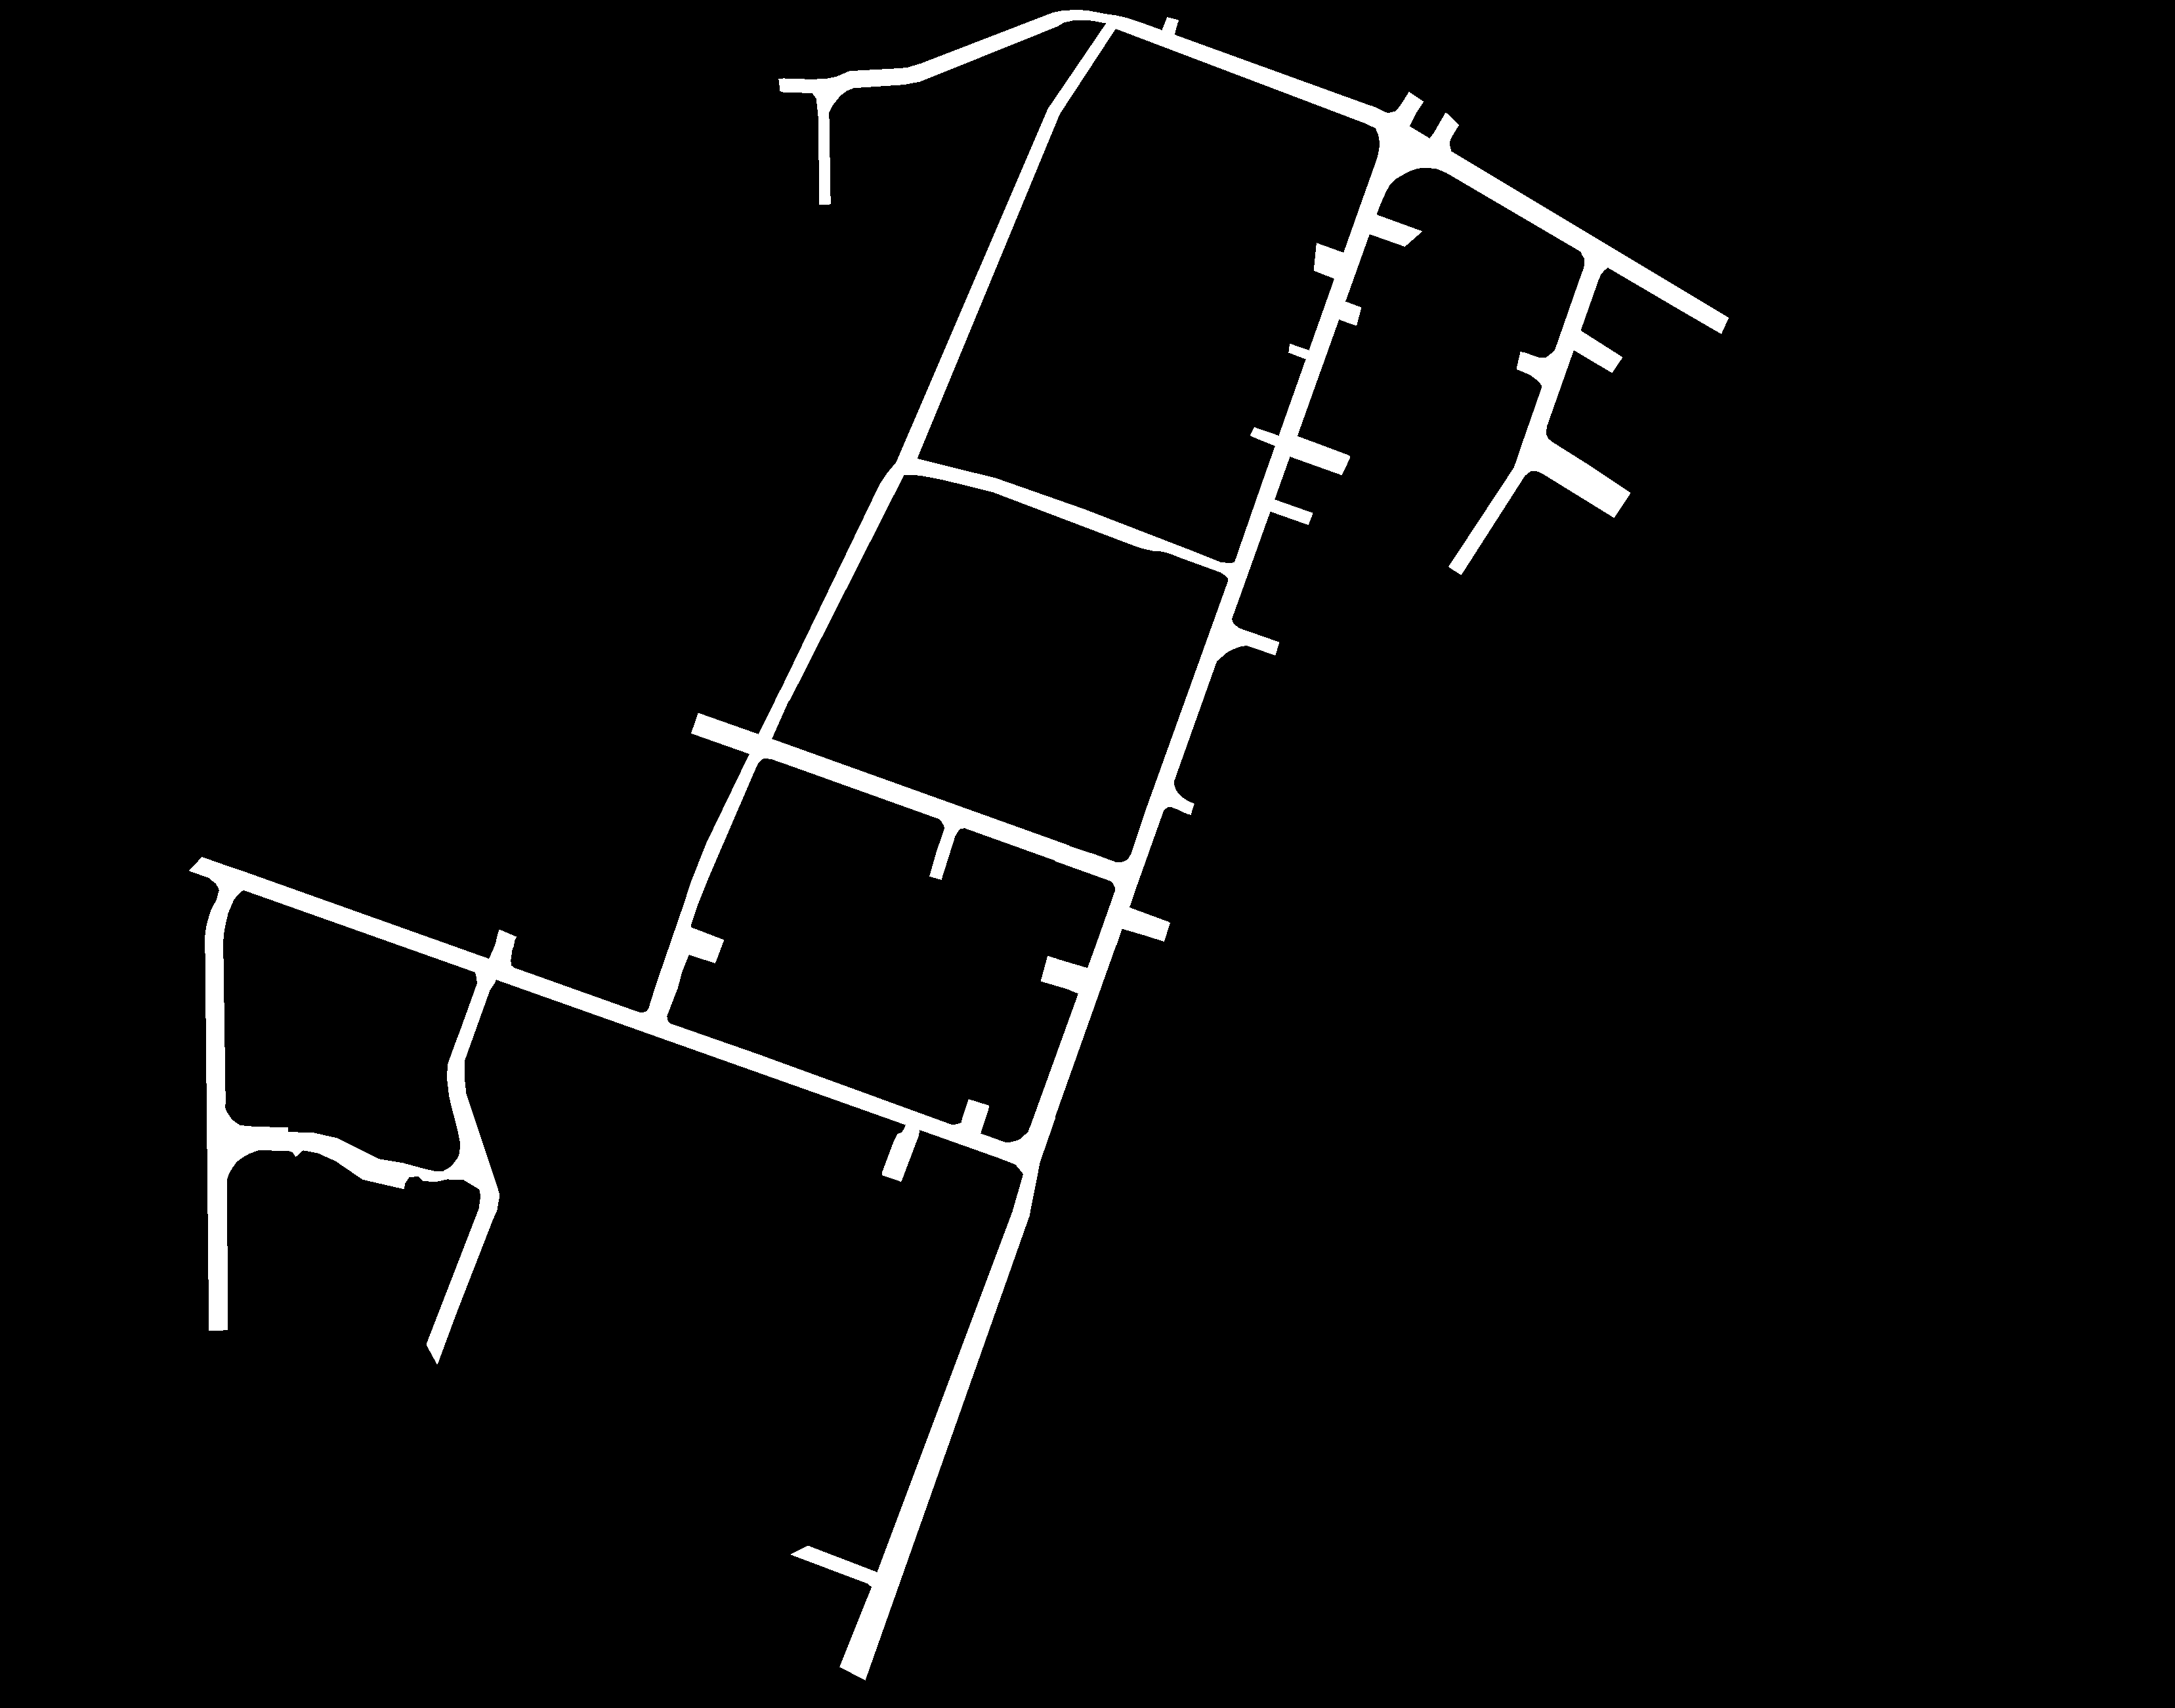

In [125]:
showarray(mapping[:, :,:])

In [302]:
import copy, cv2
import numpy as np
# crop an area with the gps as center. 

def rotate(im, angle_radian, output_size):
    m = im
    yaw = angle_radian
    
    M = cv2.getRotationMatrix2D((m.shape[1]//2, m.shape[0]//2), np.rad2deg(yaw), 1)
    dst = cv2.warpAffine(m,M,(m.shape[1],m.shape[0]))
    
    neighbour = output_size
    dst = dst[dst.shape[0]//2-neighbour: dst.shape[0]//2+neighbour, dst.shape[1]//2-neighbour:dst.shape[1]//2+neighbour, :]
    return dst

def crop_map(center, yaw):
    print (center, np.rad2deg(yaw))
    #UL = [37.919748, -122.336706]
    #LR = [37.914041, -122.328023]
    
    #UL = [37.919688, -122.338641]
    #LR = [37.911914, -122.327032]
    
    UL = [37.918355, -122.338461]
    LR = [37.911971, -122.328151]
    
    m = copy.deepcopy(mapping)
    relx = int((center[0] - UL[0]) / (LR[0] - UL[0]) * mapping.shape[0])
    rely = int((center[1] - UL[1]) / (LR[1] - UL[1]) * mapping.shape[1])
    print(relx, rely)
    neighbour =npix*3
    m = m[relx-neighbour: relx+neighbour, rely-neighbour:rely+neighbour, :]
    
    #m[m.shape[0]//2-10: m.shape[0]//2+10, m.shape[1]//2-10: m.shape[1]//2+10, :] = 0
    
    #m[relx-2:relx+2, rely-2:rely+2,:] = 0
    #showarray(m)
    dst = rotate(m, yaw, npix)
    
    dst[dst.shape[0]//2-5: dst.shape[0]//2+5, dst.shape[1]//2-5: dst.shape[1]//2+5, :] = np.array([255,0,0])
    #showarray(m)
    # cut the lower 1/3, since that might not be so useful
    dst = dst[:dst.shape[0]*2//3, :, :]
    dst = cv2.resize(dst, (int(200.0/dst.shape[0]*dst.shape[1]), 200))
    print(dst.shape, "viz shape")
    showarray(dst)


In [135]:
gps[item_gps]

(1542305076792276388, (37.915135, -122.333375))

In [132]:
item_gps

180

In [313]:
# test the general interface
sys.path.append("../../CIL_modular/utils/")
import mapping_helper
reload(mapping_helper)
helper = mapping_helper.mapping_helper(30.0, 50)

In [314]:
m = helper.get_map("rfs",gps[item_gps][1], yaw_xsens[item_yaw][1] )

In [317]:
np.

AttributeError: 'module' object has no attribute 'flatten'

(50, 75, 3)


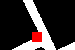

In [316]:
im2 = helper.map_to_debug_image(m)
print(im2.shape)
showarray(im2)

In [312]:
"2".zfill(3)

'002'

In [311]:
len(['Steer', 'Gas', 'Brake', 'Hand_B', 'Reverse',
                               'Steer_N', 'Gas_N', 'Brake_N',
                               'Pos_X', 'Pos_Y', 'Speed',
                               'C_Gen', 'C_Ped', 'C_Car', 'Road_I', 'Side_I', 'Acc_x', 'Acc_y', 'Acc_z',
                               'Plat_Ts', 'Game_Ts', 'Ori_X', 'Ori_Y', 'Ori_Z', 'Control', 'Camera', 'Angle',
                               'wp1_x', 'wp1_y', 'wp2_x', 'wp2_y', 'wp1_angle', 'wp1_mag', 'wp2_angle', 'wp2_mag',
                               'wp1x', 'wp1y', 'wp2x', 'wp2y', 'wp3x', 'wp3y', 'wp4x', 'wp4y', 'wp5x', 'wp5y',
                               'wp6x', 'wp6y', 'wp7x', 'wp7y', 'wp8x', 'wp8y', 'wp9x', 'wp9y', 'wp10x', 'wp10y',
                               'cluster_id', 'cluster_scale', 'town_id'])

58

200
((37.915121666666664, -122.33315), 45.052792020690454)
(1318, 1707)
((200, 300, 3), 'viz shape')


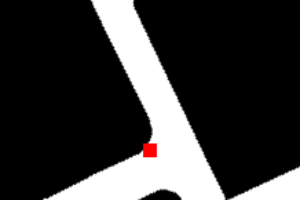

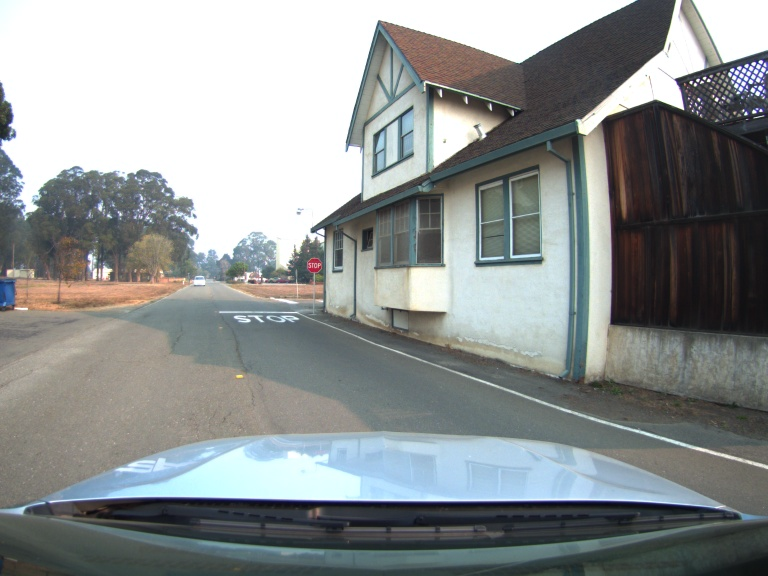

In [307]:

#item_gps = 180
#item_gps = 180
item_gps =200
print(item_gps)
yaw_nn = NN(yaw_xsens)
image_nn = NN(im)
item_yaw = yaw_nn.find_time(gps[item_gps][0])
item_image = image_nn.find_time(gps[item_gps][0])
crop_map(gps[item_gps][1], yaw_xsens[item_yaw][1])
showarray(im[item_image][1])

In [545]:
mask = (mapping[:,:,0]==255) * (mapping[:,:,1]==255) * (mapping[:,:,2]==255) *255
mask = np.stack((mask, mask, mask), axis=2)

In [378]:
mask.shape

(1120, 1340)

In [560]:
cv2.imwrite("/scratch/yang/aws_data/mkz/mapping/mask.png", mask)

True

In [561]:
im = cv2.imread("/scratch/yang/aws_data/mkz/mapping/mask_ps.png")

In [567]:
mask = im[:,:,0]> 128

In [568]:
mask = np.stack((mask, mask, mask), axis=2) * 255

In [570]:
cv2.imwrite("/scratch/yang/aws_data/mkz/mapping/mask_ps_bin.png", mask)

True

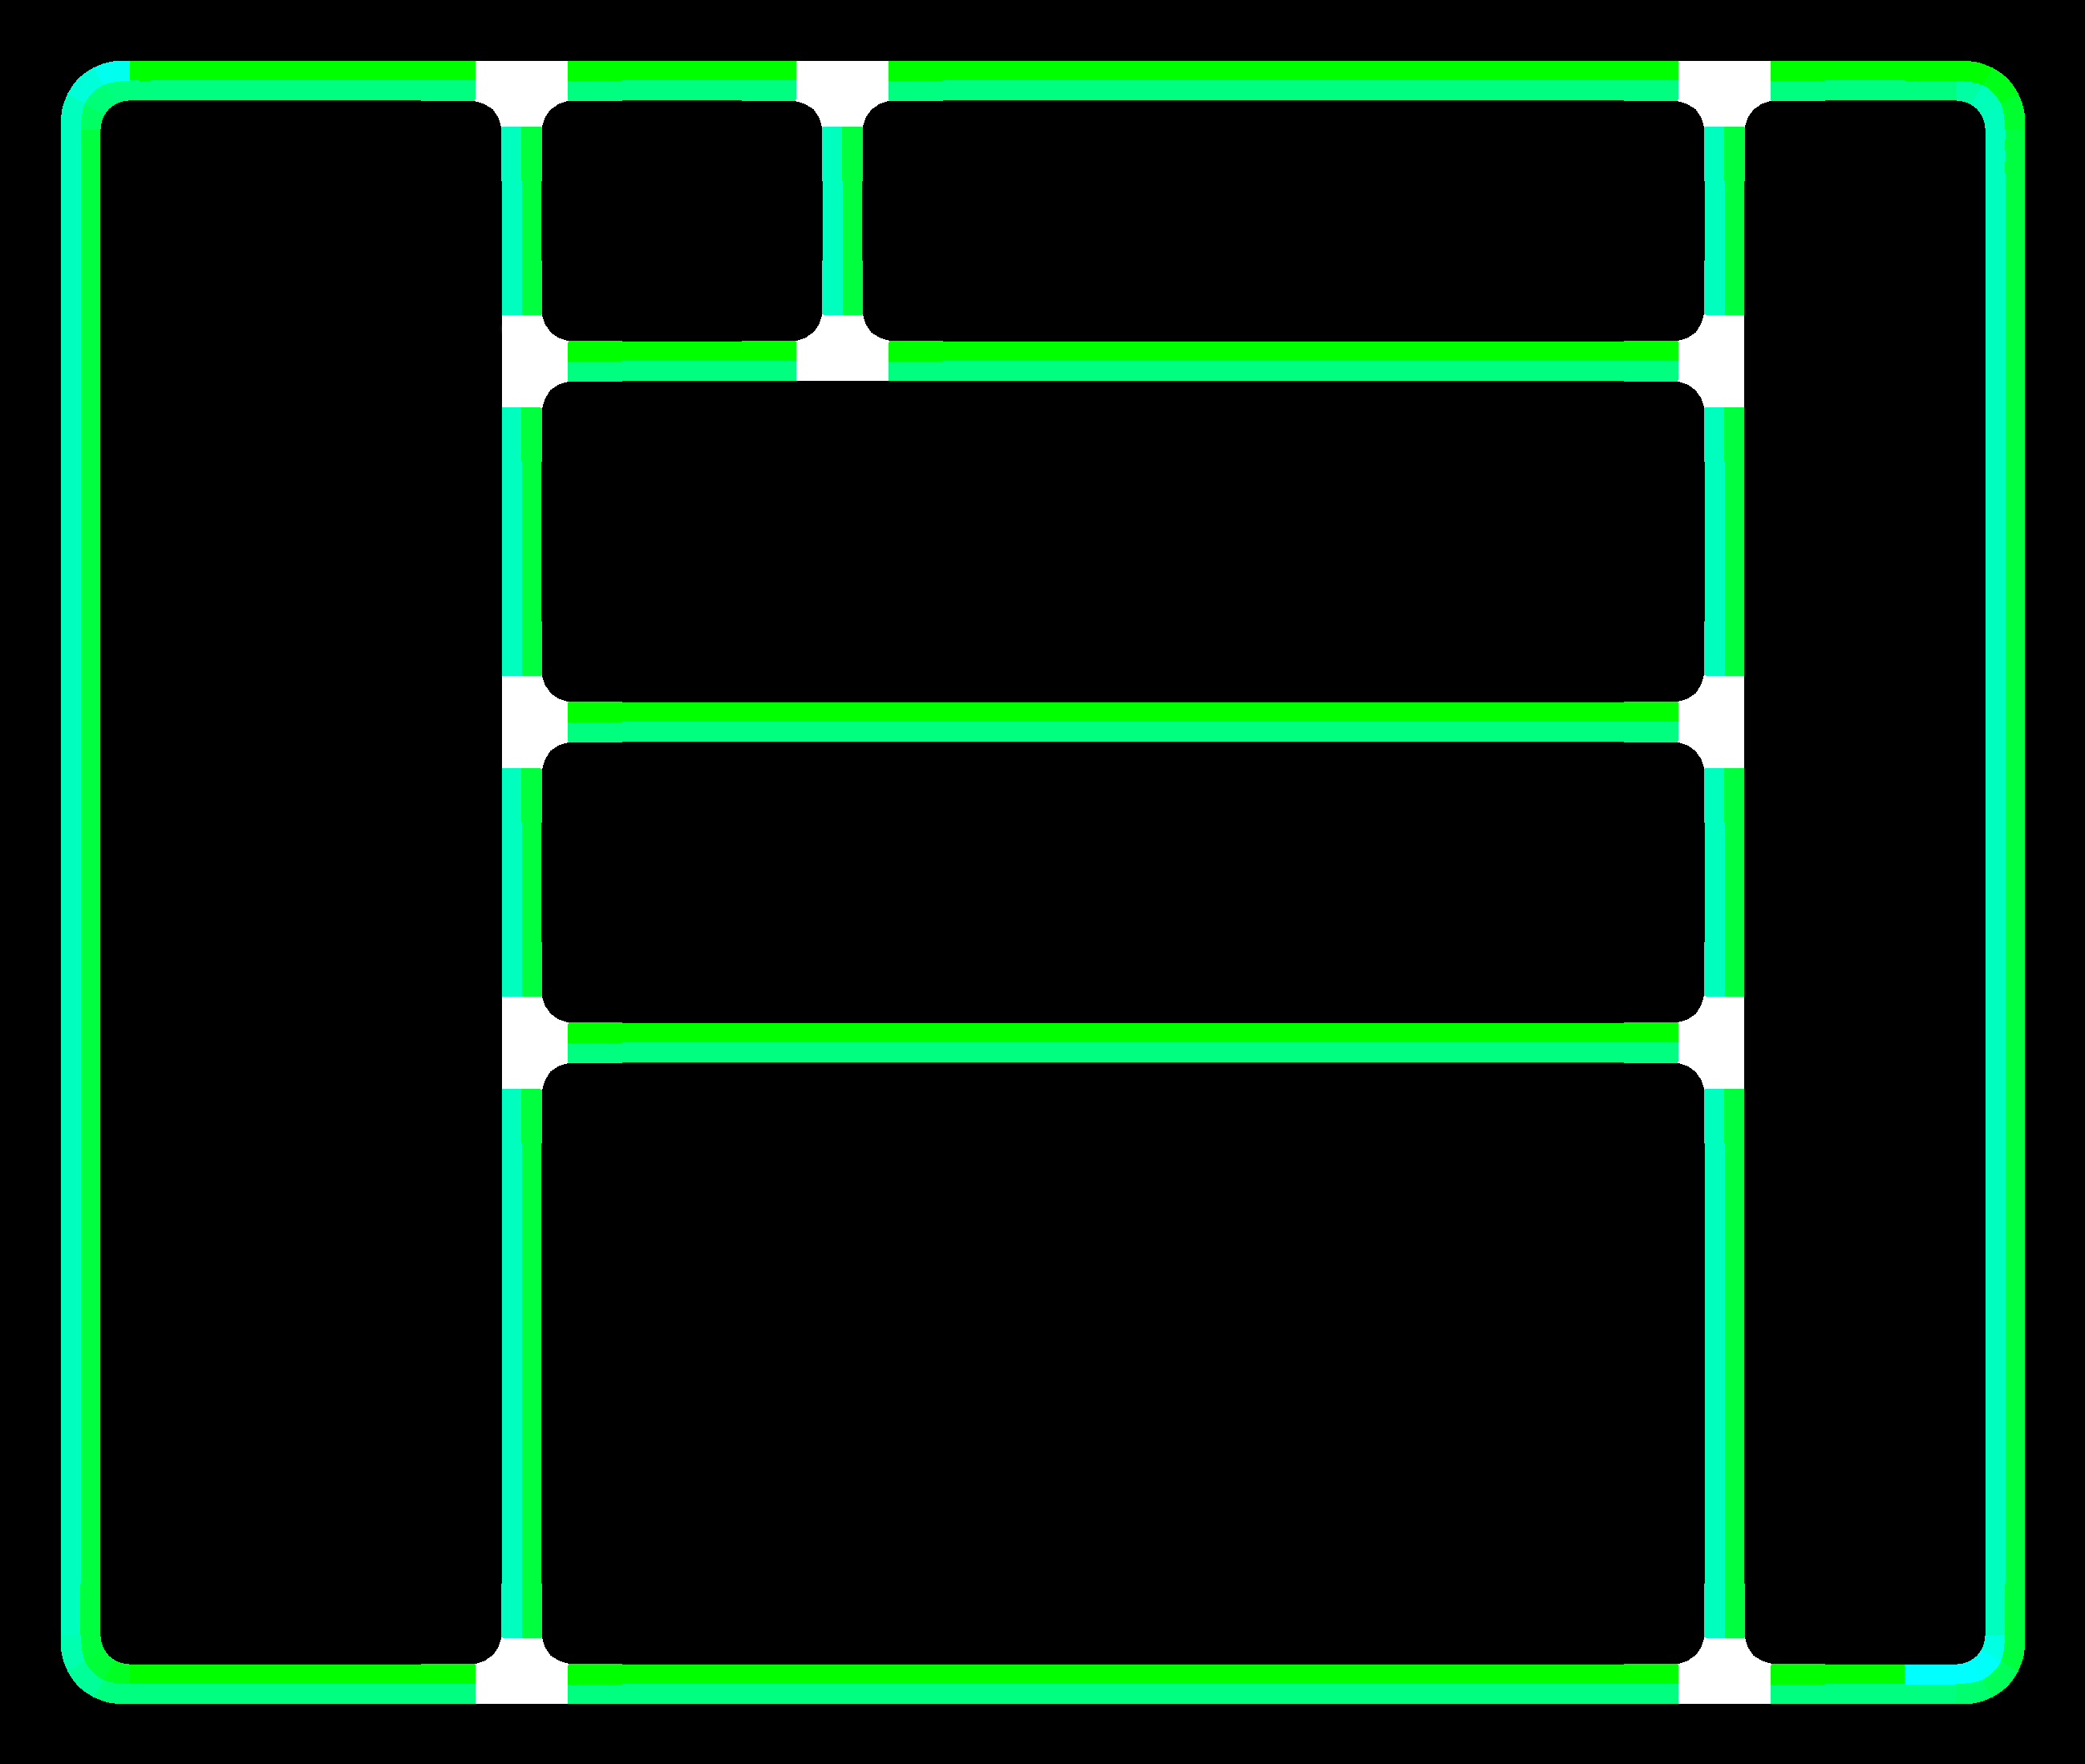

In [222]:
# now begin the exploration of the mapping within the carla town
import cv2
map_path = "/data/yang/code/aws/CIL_modular/drive_interfaces/carla/carla_client_deprecated/carla/planner/Town01Lanes.png"
mapping = cv2.imread(map_path)
mapping = mapping[:,:,::-1]
showarray(mapping)

In [750]:
h5path = "/scratch/yang/aws_data/carla_collect/steer103_v5_way_v2/default_ImageSizeX=700_WeatherId=01/data_00000.h5"

In [223]:
h5path = "/scratch/yang/aws_data/carla_collect/second_town01/default_ImageSizeX=700_WeatherId=01/data_00000.h5"
import h5py
f = h5py.File(h5path, "r")
loc = f['targets'][:, 8:10]
ori = f['targets'][:, 21:23]
im_h5 = f['CameraMiddle']


In [226]:
area = 30.0

(182, 'n pixel')
180
(array([337.7835, 323.3322], dtype=float32), array([ 0.20513415, -0.9787144 ], dtype=float32), [2613, 2701])
-11.837582761178522
(1092, 1092, 3)


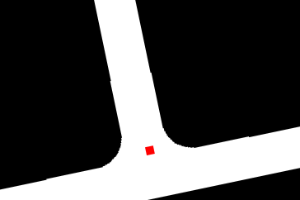

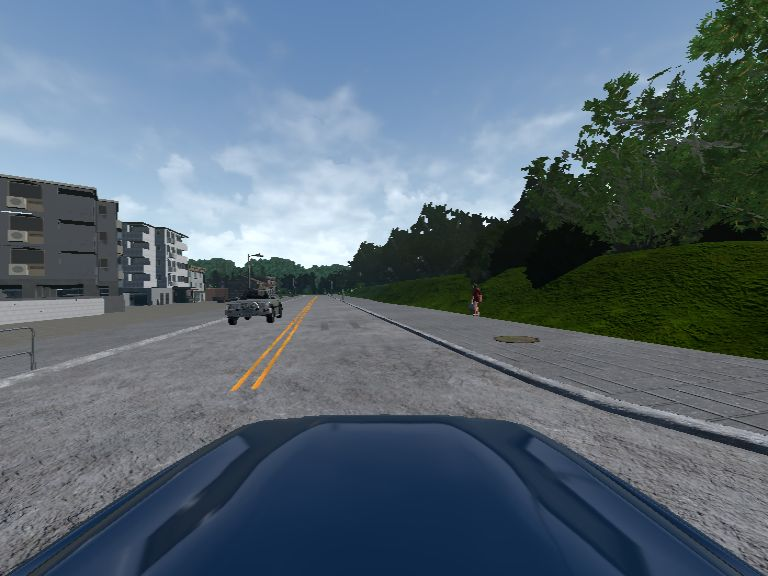

In [233]:
import sys
import numpy as np
import cv2
sys.path.append("../../CIL_modular/drive_interfaces/carla/carla_client_deprecated")
from carla.planner.map import CarlaMap
TownName="Town01"
carla_map = CarlaMap(TownName)
#mapping = carla_map.get_map()
mapping = carla_map.get_map_lanes()
mapping = np.fliplr(mapping)
mapping = mapping.astype(np.uint8)
# say we want an area with 20m * 20m
npix = int(area / 0.1643)
print(npix, "n pixel")
padding = npix*3
mapping = np.pad(mapping, ((padding, padding), (padding, padding), (0, 0)), 'constant')
mapping = mapping[:,:,:3]

def convert_lane_to_binary(mapping):
    is_back = (mapping[:,:,0]==0) * (mapping[:,:,1]==0) * (mapping[:,:,2]==0)
    is_back = (1 - is_back) * 255
    is_back = is_back.astype(np.uint8)
    return np.stack((is_back, is_back, is_back), axis=2)
mapping = convert_lane_to_binary(mapping)
    


import PIL.Image
from cStringIO import StringIO
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
import copy, cv2
import numpy as np
# crop an area with the gps as center. 

def rotate(im, angle_radian, output_size):
    m = im
    yaw = angle_radian
    
    M = cv2.getRotationMatrix2D((m.shape[1]//2, m.shape[0]//2), np.rad2deg(yaw), 1)
    dst = cv2.warpAffine(m,M,(m.shape[1],m.shape[0]))
    
    neighbour = output_size
    dst = dst[dst.shape[0]//2-neighbour: dst.shape[0]//2+neighbour, dst.shape[1]//2-neighbour:dst.shape[1]//2+neighbour, :]
    return dst    

def crop_map(carla_map, location, map_image, ori):
    #map_image = copy.deepcopy(map_image)
    cur = carla_map.convert_to_pixel([location[0], location[1], .22])
    cur = [int(cur[1])+padding, int(cur[0])+padding]
    neighbour = padding
    neighbour = map_image[cur[0]-neighbour:cur[0]+neighbour, cur[1]-neighbour: cur[1]+neighbour, :]
    sz = 5
    neighbour[neighbour.shape[0]//2-sz: neighbour.shape[0]//2+sz, neighbour.shape[1]//2-sz: neighbour.shape[1]//2+sz, :] = \
        np.array([255, 0, 0])
    print(location, ori, cur)
    yaw = np.arctan2(-ori[1], ori[0]) - np.pi/2
    print(np.rad2deg(yaw))
    print(neighbour.shape)
    neighbour = rotate(neighbour, -yaw, npix)
    neighbour = neighbour[: neighbour.shape[0]*2//3, :, :]
    dst = neighbour
    dst = cv2.resize(dst, (int(200.0/dst.shape[0]*dst.shape[1]), 200))
    showarray(dst)

#item +=3
item = 180
print(item)
crop_map(carla_map, loc[item, :], mapping, ori[item])
showarray(cv2.imdecode(im_h5[item], 1)[:,:,::-1])

In [61]:
h5path = "/scratch/yang/aws_data/carla_collect/second_town02/default_ImageSizeX=700_WeatherId=01/data_00001.h5"
h5path = "/scratch/yang/aws_data/carla_collect/rfs_sim/default_ImageSizeX=700_WeatherId=01/data_00021.h5"
import h5py, sys
f = h5py.File(h5path, "r")
loc = f['targets'][:, 8:10]
ori = f['targets'][:, 21:24]
im_h5 = f['CameraMiddle']


In [42]:
sys.path.append("../../CIL_modular/utils/")
import mapping_helper
reload(mapping_helper)
helper = mapping_helper.mapping_helper(30.0)

In [28]:
ori[item]

array([-9.5028415e-02,  2.9812720e-01, -1.4945892e+02], dtype=float32)

the new ori3


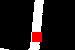

(50, 75, 3)


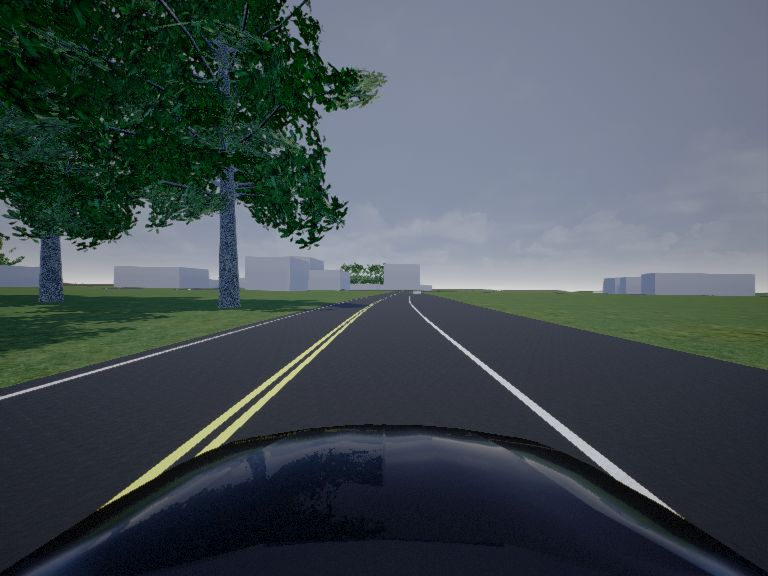

In [68]:
import cv2
item = 60
m = helper.get_map("rfs_sim", loc[item, :], ori[item])
im = helper.map_to_debug_image(m)
showarray(im)
print(im.shape)
showarray(cv2.imdecode(im_h5[item], 1)[:,:,::-1])

In [ ]:
item = 180
print(item)
crop_map(carla_map, loc[item, :], mapping, ori[item])
showarray(cv2.imdecode(im_h5[item], 1)[:,:,::-1])

In [142]:
import math
def dis(a, b):
    d=math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
    return d
dis([306.7698, 330.5395], [338.43155, 317.2702 ])

34.32988108852843

In [143]:
dis( [2311, 2167], [2231, 2359])

208.0

In [145]:
1/(208/34.32988108852843)

0.16504750523330977

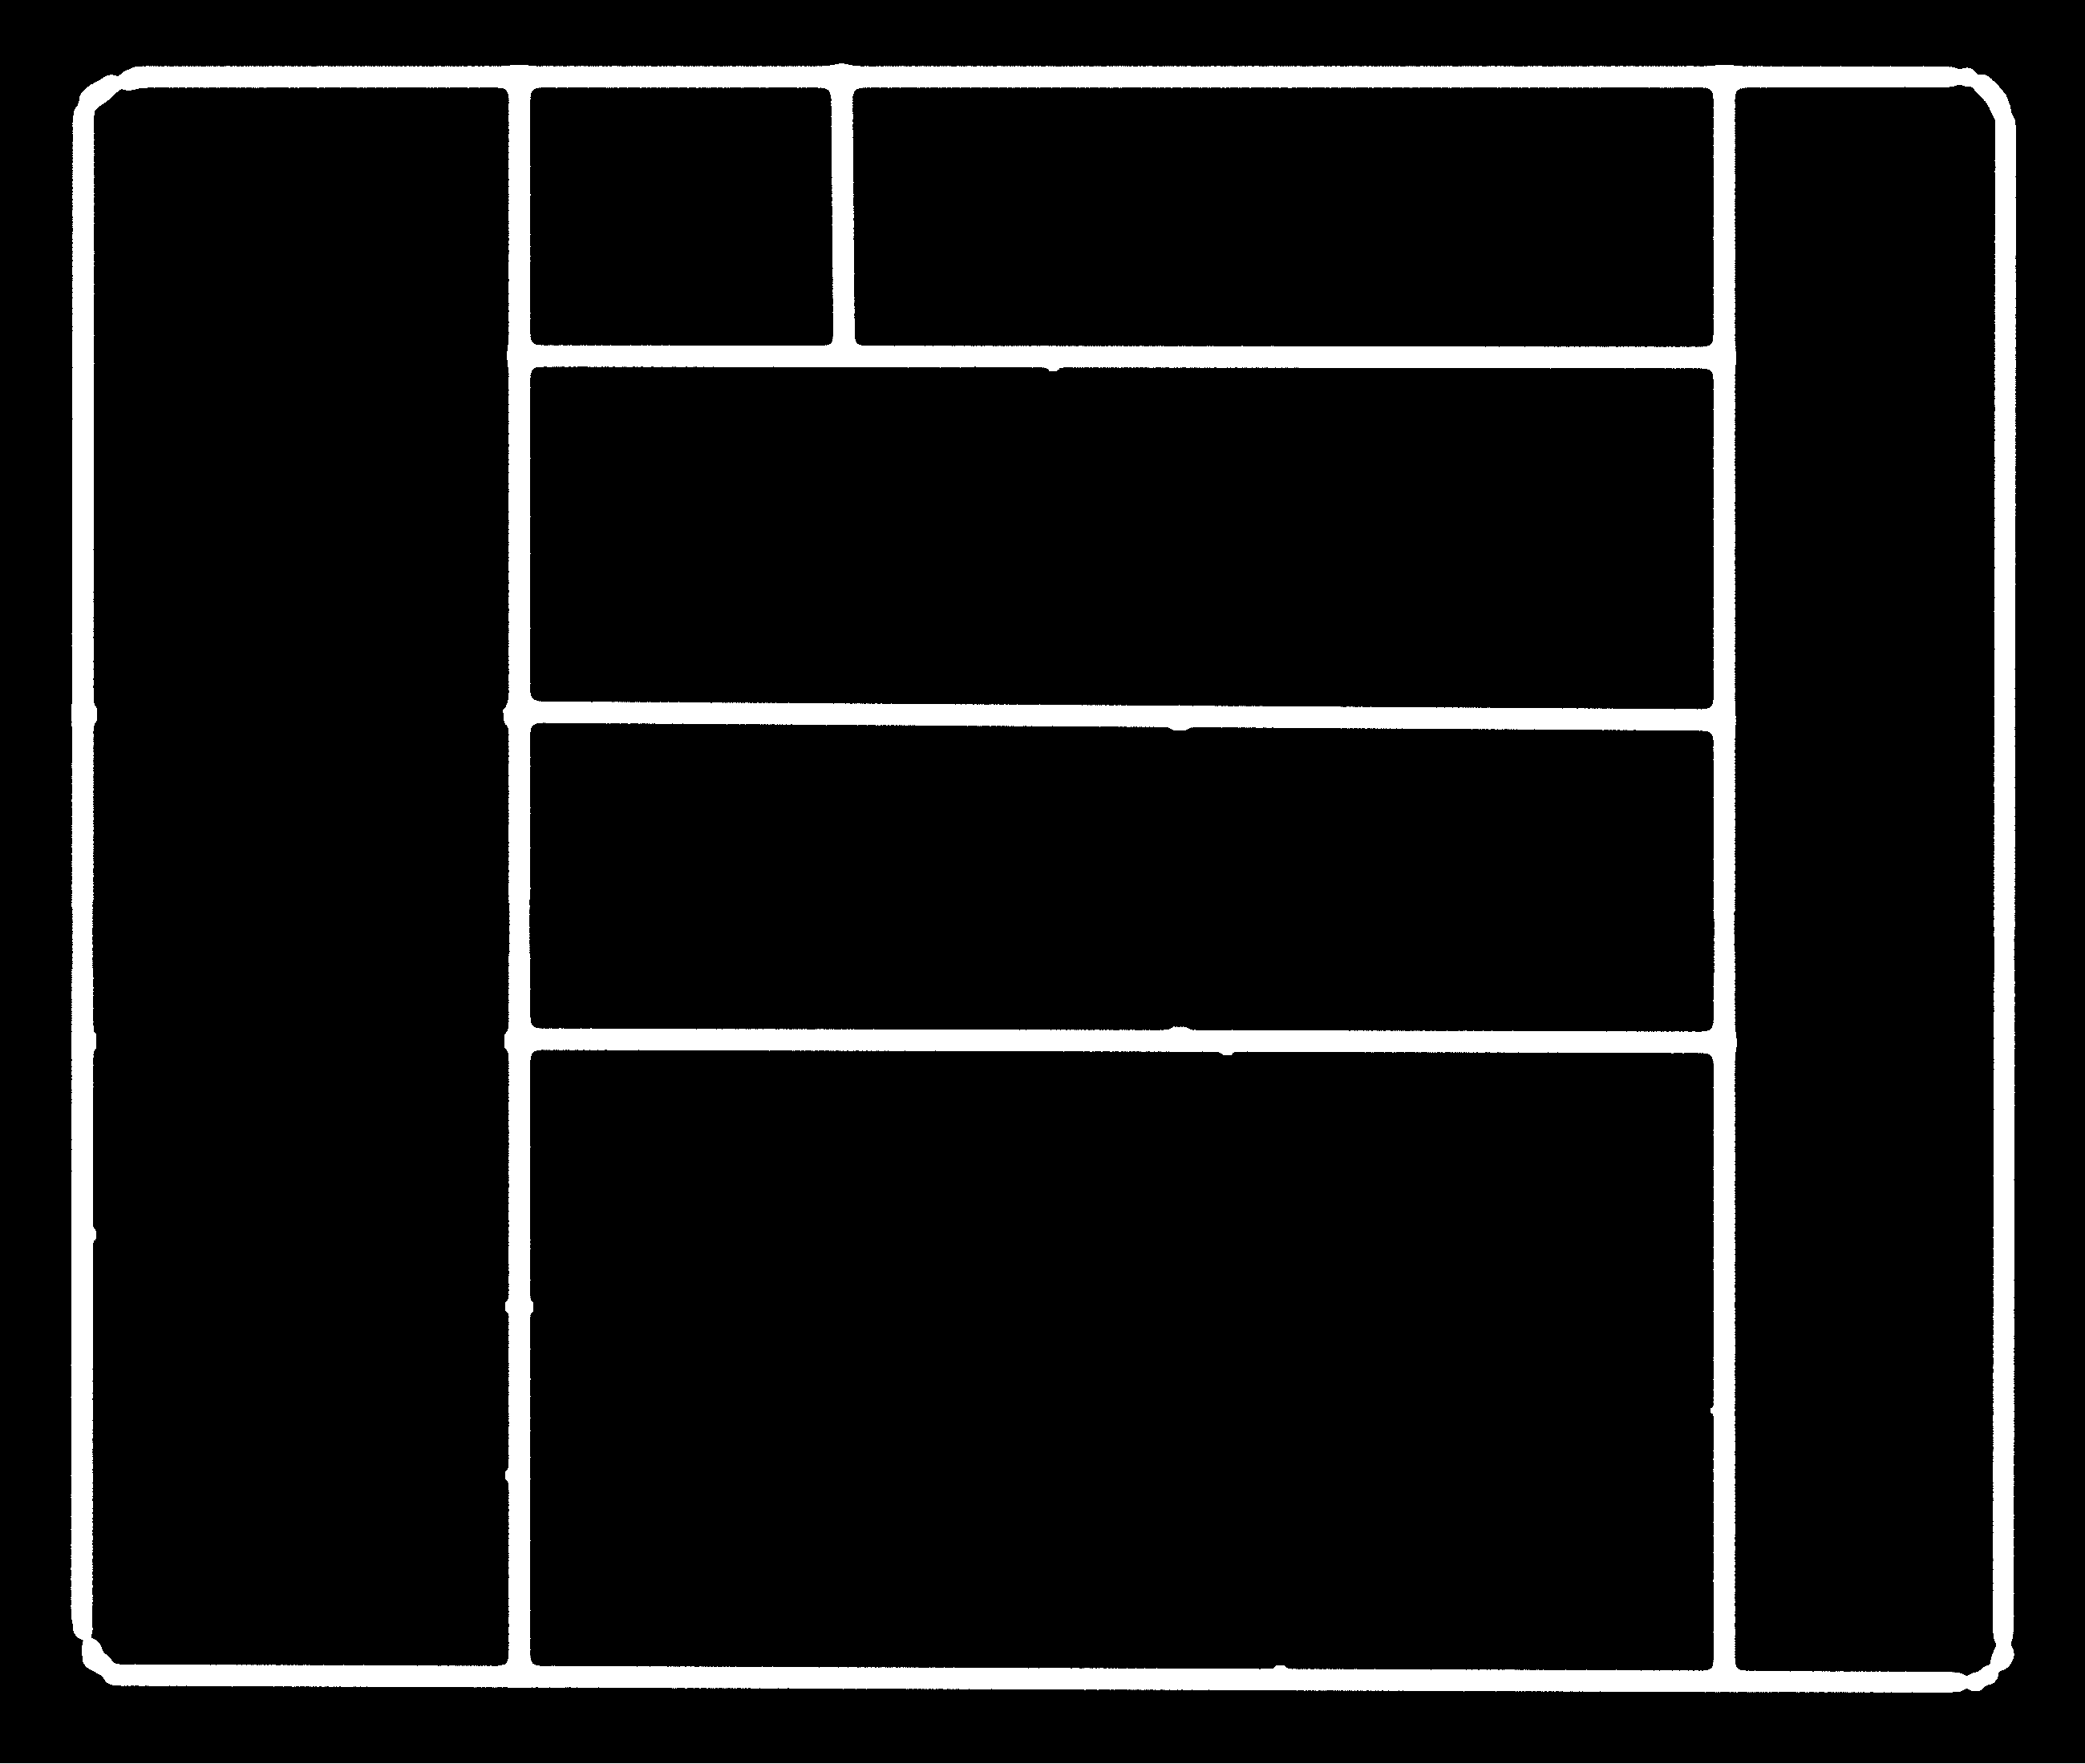

In [132]:
mask = mapping[:,:,0] == 255
mask = np.stack((mask, mask, mask), axis=2) *255
showarray(mask)

In [827]:
a=np.fromstring(im[0], dtype=np.uint8)
a

array([255, 216, 255, ...,  35, 255, 217], dtype=uint8)

SyntaxError: invalid syntax (<ipython-input-322-b6b0d5b11a6e>, line 1)

In [325]:
import collections
collections.defaultdict([1,2])

TypeError: first argument must be callable or None

In [324]:
a[2222]

KeyError: 2222

In [328]:
path = "/scratch/yang/aws_data/mkz/recordings/11.28-2/video_enable.pkl"

In [329]:
import pickle

In [330]:
with open(path, "rb") as f:
    a=pickle.load(f)

In [333]:
len(a)-3329

85